## 0. Setup Environment

Open3D, cvxpy

## 1. See data

For the experiments, we are gonna take the original pcd, and apply one, or several of the following transformations to the original (i.e. target) pcd:

1. Gaussian noise with a specified standard deviation
2. Rotation, random.
3. Translation, random, each direction is sampled from uniform distribution [0,1].

Run the cell and see the effect of allying all 3 transformations.

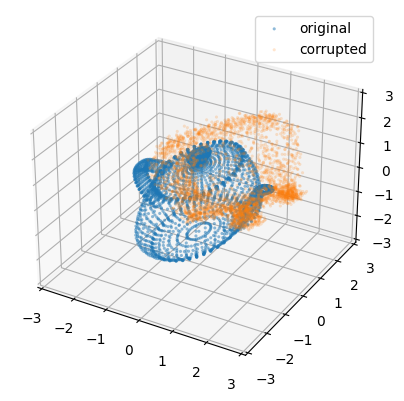

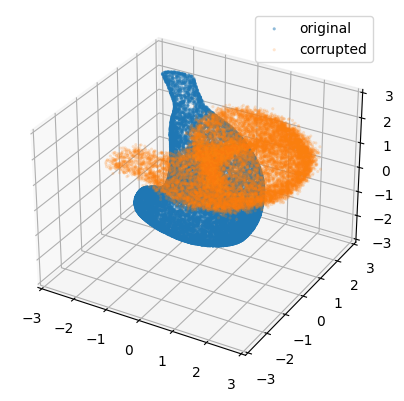

In [13]:
import pickle, numpy as np
from utils import *

pcd = pickle.load(open("./assets/teapot.target.pickle", 'rb'))
T = get_rand_transform()
r, t = T[:3,:3], T[3,:3]
compare_pcd(pcd, gaussian_corruption(pcd,std=0.1) @ r + t)

pcd = pickle.load(open("./assets/banana.target.pickle", 'rb'))
T = get_rand_transform()
r, t = T[:3,:3], T[3,:3]
compare_pcd(pcd, gaussian_corruption(pcd,std=0.1) @ r + t)

## 2. Experiments

Mainly, we will refer to [this paper](https://arxiv.org/pdf/1401.3700.pdf).

The problem formulation uses the following notations:

- $X,Y\in\mathbb{R}^{3\times N}$: Source and target point cloud
- $R\in\mathbb{SO}(3), t\in\mathbb{R}^3$: Rotation, translation applied to source pcd
- $S=\begin{bmatrix}R&t\\0&1\end{bmatrix}\in\mathbb{SE}(3)\subset \mathbb{R}^{4\times 4}$: The rotation and translation in one matrix 
- $[\bullet]$ denotes the skew-symmetric operator.

Primal formulation of the problem is:
$$\begin{align*}
\min_R \Vert SX-Y \Vert_F^2, \quad\text{s.t. } S\in\mathbb{SE}(3)
\end{align*}$$

### 2.0. Naive least-square relaxation

The naive relaxation is to drop the translation term, and only try to regress the rotation.

The primal problem becomes:
$$\begin{align*}
\min_R \Vert RX-Y \Vert_F^2, \quad\text{s.t. } R\in\mathbb{SO}(3)
\end{align*}$$


Let $R(R_0, \omega)=R_0\exp([\omega])\approx R_0+R_0[\omega]$ be a parameterization of rotation matrix $R$, based on an initial guess of rotation $R_0$, where the small angle $\omega\approx\mathbf{0}\in\mathbb{R}^3$ is the parameter subject to optimization. The relaxed objective function is approximately linear w.r.t. $\omega$, and the optimization problem becomes:
$$\begin{align*}
\min_\omega \Vert A\omega-B \Vert_F^2 \quad\text{s.t. } \Vert \omega \Vert_2^2\leq\epsilon
\end{align*}$$
where $\epsilon\neq0$ is a small positive number. Then we derive $A,B$ by re-expressing $RX-Y$:
$$\begin{align*}
(RX-Y)_{:i}&= R_0X_{:i}+R_0[\omega]X_{:i}-Y_{:i}\\
&=-R_0\left[X_{:i}\right] \omega-\left(Y_{: i}-R_0 X_{:i}\right) &([u] v=-[v] u)\\
&= A_{:i}\omega-B_{:i}\\
\text{where } A_{:i}&= -R_0[X_{:i}], \;B_{:i}=Y_{:i}-R_0X_{:i}
\end{align*}$$

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


 52%|█████▏    | 103/200 [00:10<00:09,  9.75it/s]


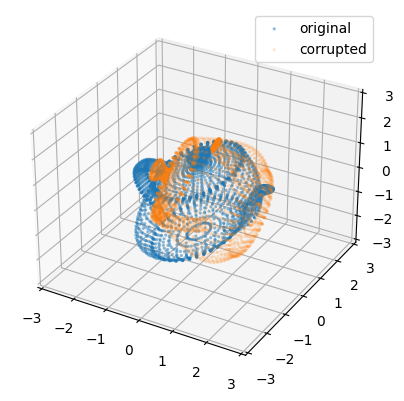

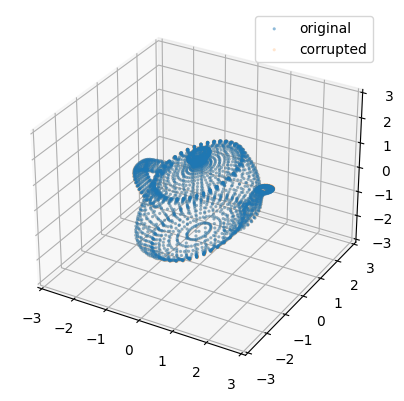

100%|██████████| 200/200 [00:18<00:00, 10.55it/s]


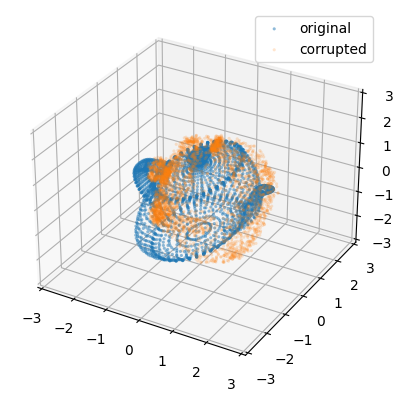

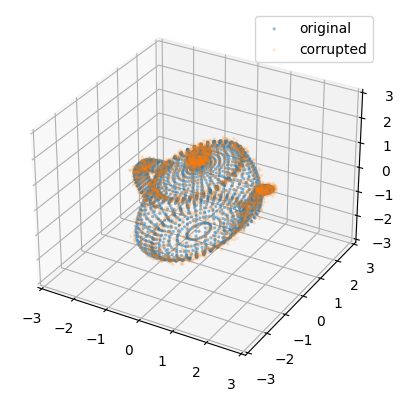

In [1]:
import numpy as np, pickle
from utils import *
from solvers import *


''' Prepare the problem (rotation only) '''
r = get_rand_rotation()
X = pickle.load(open("./assets/teapot.pickle", 'rb'))  # (N,3)
X = X.T     # (3,N)
Y1 = r @ X                                  # Rotation
Y2 = r @ gaussian_corruption(X, std=0.05)   # Rotation + gaussian


''' Solve '''
R = LinearRelaxationSolver().solve(X,Y1)
compare_pcd(X.T, Y1.T)
compare_pcd(X.T, Y1.T @ R)

R = LinearRelaxationSolver().solve(X,Y2)
compare_pcd(X.T, Y2.T)
compare_pcd(X.T, Y2.T @ R)

### 2.1. The [Umeyama's approach](https://web.stanford.edu/class/cs273/refs/umeyama.pdf)

The SVD approach works when rotation and translation are both applied. We anticipate the following short-comings, which are to be addressed by the convex-relaxation approach:
1. Lack of robustness to gaussian noise
2. Lack of robustness to outliers (e.g. a portion of pcd that's translated independently from the rest of the pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.



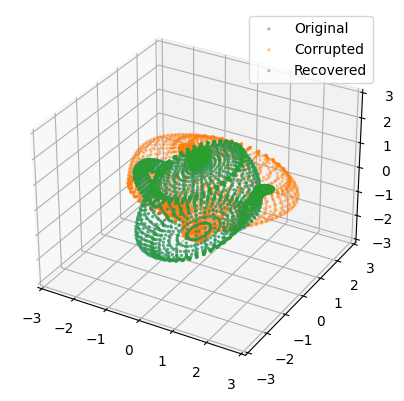

<Figure size 640x480 with 0 Axes>

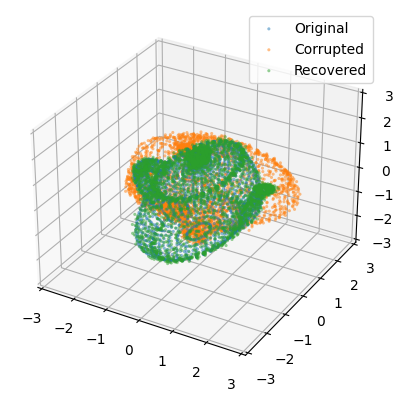

<Figure size 640x480 with 0 Axes>

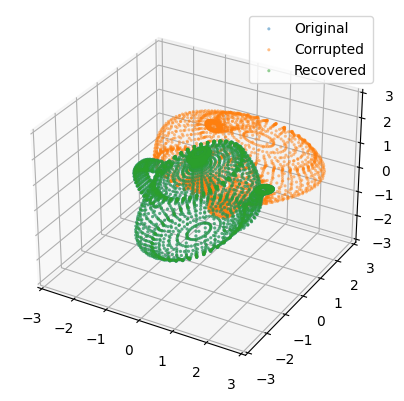

<Figure size 640x480 with 0 Axes>

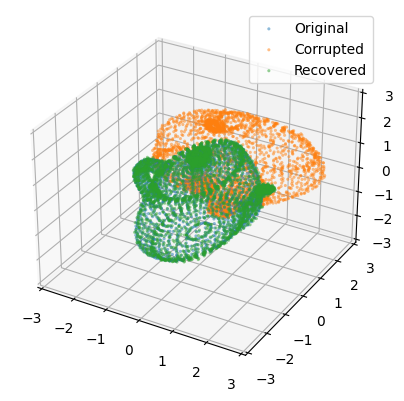

<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np, pickle
from utils import *
from solvers import *


''' Prepare the problem (rotation only) '''
rot = get_rand_rotation()
trans = get_rand_translation()
Y = pickle.load(open("./assets/teapot.pickle", 'rb')).T  # (3, N)

X1 = rot @ Y                                        # Rotation
X2 = rot @ gaussian_corruption(Y, std=0.05)         # Rotation + gaussian
X3 = ((rot @ Y).T + trans).T                        # Rotation + translation
X4 = ((rot @ gaussian_corruption(Y)).T + trans).T   # Rotation + translation + gaussian
# TODO: Partial translation to create outliers


''' Solve '''
R, t = LeastSquareSolver().solve(X1, Y)
compare_pcd([Y.T, X1.T, (R @ X1).T + t])

R, t = LeastSquareSolver().solve(X2, Y)
compare_pcd([Y.T, X2.T, (R @ X2).T + t])

R, t = LeastSquareSolver().solve(X3, Y)
compare_pcd([Y.T, X3.T, (R @ X3).T + t])

R, t = LeastSquareSolver().solve(X4, Y)
compare_pcd([Y.T, X4.T, (R @ X4).T + t])

### 2.3. Convex relaxation approach.

The convex relaxation approach should be robust to gaussian noise and outliers, but with the shortcoming of requiring strict correspondence between the source and the target pcd.